In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy # CUDA interface for python
%load_ext autoreload
%autoreload 2
%load_ext autotime
import FastQSL

time: 625 ms (started: 2021-11-18 23:43:02 +08:00)


In [2]:
cupy.__version__

'9.5.0'

time: 0 ns (started: 2021-11-18 23:43:04 +08:00)


In [31]:
a = sciIO.readsav('../TD6.sav')
#a = sciIO.readsav('../B0.sav')
print(a.keys())

dict_keys(['bx', 'by', 'bz', 'xreg_kt', 'yreg_kt', 'zreg_kt', 'resolution'])
time: 10.6 s (started: 2021-11-18 23:52:37 +08:00)


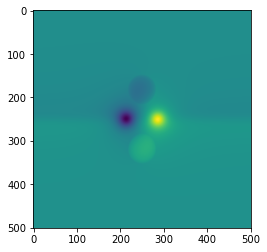

time: 1.92 s (started: 2021-11-18 23:52:48 +08:00)


In [32]:
# need to be transposed because of the storage toplogy

if False:
    Bx = np.transpose(a.twbox[0].bx,(2,1,0)).astype(np.float32)
    By = np.transpose(a.twbox[0].by,(2,1,0)).astype(np.float32)
    Bz = np.transpose(a.twbox[0].bz,(2,1,0)).astype(np.float32)
    (Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False
    
else:
    Bx = np.transpose(a.bx,(2,1,0)).astype(np.float32)
    By = np.transpose(a.by,(2,1,0)).astype(np.float32)
    Bz = np.transpose(a.bz,(2,1,0)).astype(np.float32)
    (Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False

plt.imshow(Bz[:,:,0].T) 

In [33]:
Bz.shape

(501, 501, 501)

time: 0 ns (started: 2021-11-18 23:52:58 +08:00)


In [34]:
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineScott.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBlineScott = TraceFunc.get_function("TraceAllBlineScott")
#print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)
    
dummy=cupy.zeros([1,1],dtype=cupy.float32)
flag_twist=cupy.array([False],dtype=cupy.bool_)

compiling kernel
transfering B-field to GPU
time: 969 ms (started: 2021-11-18 23:53:03 +08:00)


In [35]:
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
BshapeN = cupy.array(BshapeN)

interp_ratio=4
stride_step=1/interp_ratio
# full image
x_range = [0,1163]
y_range = [0,487]
# active region
x_range = [350,670]
y_range = [180,430]

x_range = [450,570]
y_range = [240,360]

x_range = [100,400]
y_range = [100,400]

x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
x_arr,y_arr = cupy.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()

#z_inp[:] = +23.583333

if not flag_init:
    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    flag_init=True

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1./8.],cupy.float32)
tol_coef = cupy.array([1.],cupy.float32)


inp_norm = cupy.array([0,0,1.],cupy.float32)

# for GTX 1060
# blck=(64,1,1)
# grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)
cupy.cuda.stream.get_current_stream().synchronize()

time: 0 ns (started: 2021-11-18 23:53:11 +08:00)


In [45]:
tol_coef_arr = cupy.array([10**1.5,10**0.5,10**0.0,10**-0.5],dtype=cupy.float32)/10**(2)
#tol_coef_arr = cupy.array([1],dtype=cupy.float32)
Qall_arr=cupy.zeros([*xy_shape,tol_coef_arr.shape[0]],dtype=cupy.float32)

time: 0 ns (started: 2021-11-18 23:55:20 +08:00)


In [46]:
import tqdm
for idx_tol,real_tol in tqdm.tqdm(enumerate(tol_coef_arr)):
    
    (x_start,y_start,z_start, x_end,y_end,z_end,
    Bx_inp,By_inp,Bz_inp,q_0_gpu,q_perp_gpu
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(11)]
    (flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(2)]
    
    
    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = (cupy.zeros_like(x_inp,cupy.float32))+10
    # run the big calclation
    TraceAllBlineScott(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
                  dummy,dummy,dummy,dummy,flag_twist,
                x_inp,   y_inp,   z_inp,inp_norm,
                x_start, y_start, z_start, flag_start,
                x_end,   y_end,   z_end,   flag_end,
                Bx_inp,  By_inp,  Bz_inp,
                q_0_gpu,q_perp_gpu,
                s_len,N,line_len, real_tol))
    (x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
     x_start_arr, y_start_arr,z_start_arr, flag_start_arr, 
     q_0_gpu_arr, q_perp_gpu_arr,
     Bx_0_arr,    By_0_arr,   Bz_0_arr) = FastQSL.ResReshape(xy_shape,
                    x_end,y_end,z_end,flag_end,
                    x_start,y_start,z_start,flag_start,
                    q_0_gpu, q_perp_gpu,
                    Bx_inp,By_inp,Bz_inp)
    cupy.cuda.stream.get_current_stream().synchronize()

    Q_all=q_0_gpu_arr

    Qall_arr[:,:,idx_tol]=Q_all
    
    cupy.cuda.stream.get_current_stream().synchronize()
    (x_start,y_start,z_start, x_end,y_end,z_end,z_inp,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[None for _ in range(16)]
    (B_flag,flag_start,flag_end)=[None for _ in range(3)]

4it [00:20,  5.08s/it]

time: 20.3 s (started: 2021-11-18 23:55:26 +08:00)


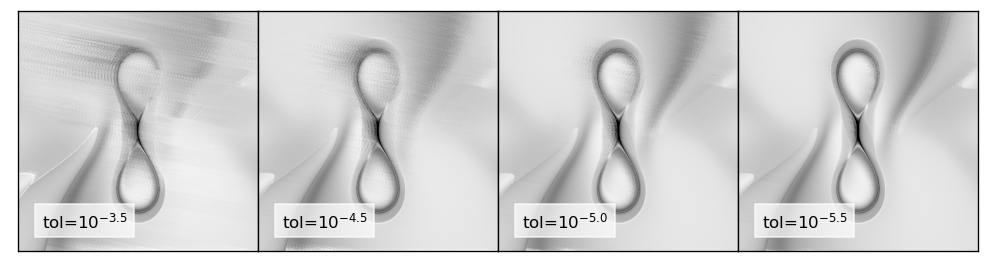

time: 1.23 s (started: 2021-11-18 23:55:47 +08:00)


In [47]:
axis_r=0.366
dpi=120

Qall_arr[np.where(Qall_arr<1.0)]=1.0

x_range_real = np.array(x_range)*axis_r
y_range_real = np.array(y_range)*axis_r

fig=plt.figure(13,dpi=dpi,figsize=[8,2]);

ax0 = fig.add_axes([0,0,1/4,1])
ax1 = fig.add_axes([1/4,0,1/4,1])
ax2 = fig.add_axes([2/4,0,1/4,1])
ax3 = fig.add_axes([3/4,0,1/4,1])

ax0.imshow(np.log10(Qall_arr[:,:,0].get()),#*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',
                extent=[*x_range_real,*y_range_real])
#ax0.set_xlim([165,195])
#ax0.set_ylim([95,125])
#ax0.axes.get_xaxis().set_ticks([170,180,190])
#ax0.axes.get_yaxis().set_ticks([100,110,120])
ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])

ax1.imshow(np.log10(Qall_arr[:,:,1].get()),#*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',
                extent=[*x_range_real,*y_range_real])
#ax1.set_xlim([165,195])
#ax1.set_ylim([95,125])
#ax1.axes.get_xaxis().set_ticks([170,180,190])
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])


ax2.imshow(np.log10(Qall_arr[:,:,2].get()),#*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',
                extent=[*x_range_real,*y_range_real])
#ax2.set_xlim([165,195])
#ax2.set_ylim([95,125])
#ax2.axes.get_xaxis().set_ticks([170,180,190])
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])

ax3.imshow(np.log10(Qall_arr[:,:,3].get()),#*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',
                extent=[*x_range_real,*y_range_real])
#ax3.set_xlim([165,195])
#ax3.set_ylim([95,125])
#ax3.axes.get_xaxis().set_ticks([170,180,190])
ax3.axes.get_xaxis().set_ticks([])
ax3.axes.get_yaxis().set_ticks([])


ax0.text(0.1,0.1,r'tol=$\rm{10^{'+str(-3+np.log10(tol_coef_arr[0]))+'}}$',transform = ax0.transAxes,backgroundcolor=[1,1,1,0.7])
ax1.text(0.1,0.1,r'tol=$\rm{10^{'+str(-3+np.log10(tol_coef_arr[1]))+'}}$',transform = ax1.transAxes,backgroundcolor=[1,1,1,0.7])
ax2.text(0.1,0.1,r'tol=$\rm{10^{'+str(-3+np.log10(tol_coef_arr[2]))+'}}$',transform = ax2.transAxes,backgroundcolor=[1,1,1,0.7])
ax3.text(0.1,0.1,r'tol=$\rm{10^{'+str(-3+np.log10(tol_coef_arr[3]))+'}}$',transform = ax3.transAxes,backgroundcolor=[1,1,1,0.7])

fig.savefig('tol_td_scott.pdf')#,bbox_inches='tight',pad_inches=0.1)

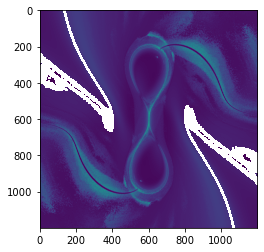

time: 313 ms (started: 2021-11-18 23:20:32 +08:00)


In [71]:
plt.imshow(np.log10(Qall_arr[:,:,0].get()))

(95.0, 125.0)

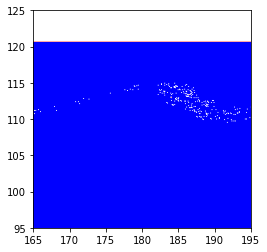

time: 125 ms (started: 2021-11-18 22:33:54 +08:00)


In [25]:
plt.imshow(((Qall_arr[:,:,3].get())<1.000001),#*np.sign(Bz_0_arr.get()),
                cmap='bwr',origin='lower',
                extent=[*x_range_real,*y_range_real])
plt.gca().set_xlim([165,195])
plt.gca().set_ylim([95,125])

In [11]:
np.where(np.isnan(Qall_arr[:,:,3].get()))

(array([656, 656, 656, ..., 998, 998, 998], dtype=int64),
 array([   1,    2,    3, ..., 1080, 1276, 1277], dtype=int64))

time: 0 ns (started: 2021-04-29 21:41:18 +08:00)
